<>:862: SyntaxWarning: invalid escape sequence '\D'
<>:862: SyntaxWarning: invalid escape sequence '\D'
C:\Users\raghu\AppData\Local\Temp\ipykernel_67792\229295321.py:862: SyntaxWarning: invalid escape sequence '\D'
  plt.savefig(f"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\plots\synthetic_v5_{feature}.png")


Loaded StandardScaler and categorical artifacts.
Engineered features - observed min: [-1.87890062 -1.67309039 -1.79624861 -1.3500817 ] max: [1.49563575 1.70671805 1.41547433 1.37969415]
Created cyclic encodings for time features
Fitted GMM for amount: means=[ 2.20518672 -0.64093358], weights=[0.77666058 0.22333942]
Fitted GMM for age: means=[ 0.96008235 -0.6285999 ], weights=[0.49597272 0.50402728]
Using device: cuda


d:\ProgramData\anaconda3\envs\Env1\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\ProgramData\anaconda3\envs\Env1\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "d:\ProgramData\anaconda3\envs\Env1\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\ProgramData\anaconda3\envs\Env1\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "d:\ProgramData\anaconda3\envs\Env1\Lib\subprocess.py", line 1538, in _exec

Categorical vocabulary sizes: {'merchant': 693, 'category': 14, 'gender': 2, 'street': 999, 'city': 906, 'state': 51, 'zip': 985, 'job': 497}


d:\ProgramData\anaconda3\envs\Env1\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting training with enhanced distribution modeling…
Epoch [1/550], Loss: 10.8680
Epoch [10/550], Loss: 7.7144
Epoch [20/550], Loss: 6.7262
Epoch [30/550], Loss: 6.5236
Epoch [40/550], Loss: 5.5501
Epoch [50/550], Loss: 5.4205
Epoch [60/550], Loss: 4.9544
Epoch [70/550], Loss: 4.4369
Epoch [80/550], Loss: 4.6568
Epoch [90/550], Loss: 4.3397
Epoch [100/550], Loss: 4.1210
Epoch [110/550], Loss: 4.2789
Epoch [120/550], Loss: 4.1230
Epoch [130/550], Loss: 4.1764
Epoch [140/550], Loss: 3.9337
Epoch [150/550], Loss: 3.9824
Epoch [160/550], Loss: 3.8940
Epoch [170/550], Loss: 3.6527
Epoch [180/550], Loss: 3.5106
Epoch [190/550], Loss: 3.7303
Epoch [200/550], Loss: 3.2876
Epoch [210/550], Loss: 3.8902
Epoch [220/550], Loss: 4.0066
Epoch [230/550], Loss: 3.5618
Epoch [240/550], Loss: 3.4977
Epoch [250/550], Loss: 3.3903
Epoch [260/550], Loss: 3.5295
Epoch [270/550], Loss: 3.7964
Epoch [280/550], Loss: 3.4072
Epoch [290/550], Loss: 3.3788
Epoch [300/550], Loss: 3.2583
Epoch [310/550], Loss: 3.

C:\Users\raghu\AppData\Local\Temp\ipykernel_67792\229295321.py:862: SyntaxWarning: invalid escape sequence '\D'
  plt.savefig(f"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\plots\synthetic_v5_{feature}.png")


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\DS Northeastern\\DS 5500 - Capstone\\FraudFusion\\plots\\synthetic_v5_amt.png'

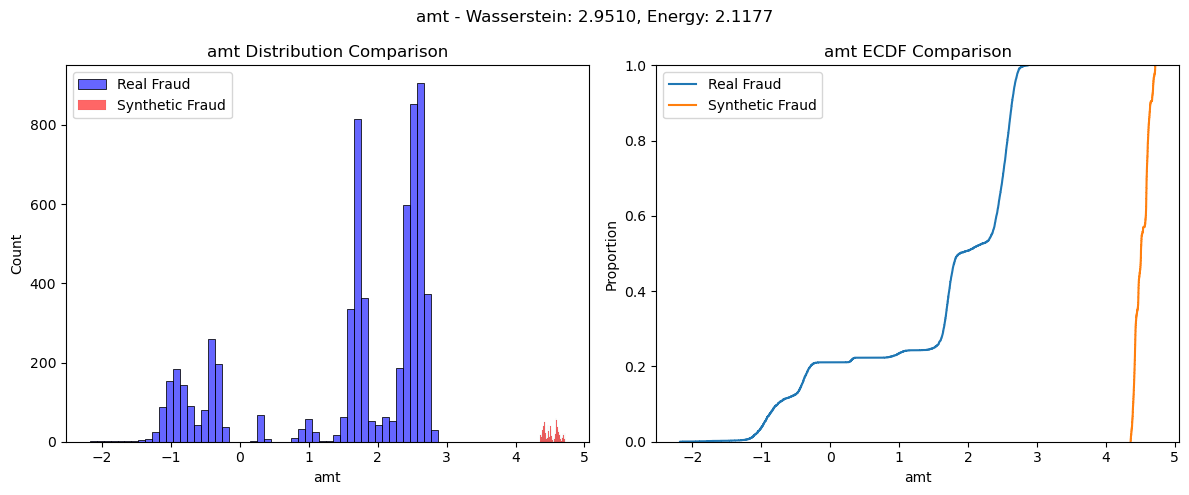

In [1]:
"""
Improved FraudDiffuse Model – Version 5 with Enhanced Distribution Modeling
Building on v4 with targeted improvements:
  • Specialized modeling for amount (amt) feature to capture bimodal distribution
  • Improved age distribution modeling
  • Enhanced generation process with feature-specific adjustments
  • Maintains all numerical stability improvements from v4
"""

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import math
from scipy import stats
from scipy.stats import wasserstein_distance, energy_distance
from sklearn.mixture import GaussianMixture

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True

#############################################
# Step 1: Load Preprocessed Data & Artifacts
#############################################
# Use raw strings to avoid escape-sequence issues.
X_train_df = pd.read_csv(r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\Data\processed\X_train.csv")
y_train_df = pd.read_csv(r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\Data\processed\y_train.csv")

scaler = joblib.load(r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\Data\processed\standard_scaler.pkl")
cat_vocab = joblib.load(r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\Data\processed\cat_vocab.pkl")
cat_mapping = joblib.load(r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\Data\processed\cat_mapping.pkl")
print("Loaded StandardScaler and categorical artifacts.")

# Define feature lists exactly as used during preprocessing.
# All numeric features were standard-scaled.
numeric_features = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long',
                    'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']
# Categorical features (factorized)
cat_features = ['merchant', 'category', 'gender', 'street', 'city', 'state', 'zip', 'job']

# Get target values (assume first column in y_train_df is target).
y_train = y_train_df.iloc[:, 0]

# Create masks.
fraud_mask = (y_train == 1)
nonfraud_mask = (y_train == 0)

# Filter training data.
X_train_num = X_train_df[numeric_features].loc[fraud_mask].values   # Standard-scaled numeric features.
X_train_cat = X_train_df[cat_features].loc[fraud_mask].values         # Integer codes.

X_nonfraud_num = X_train_df[numeric_features].loc[nonfraud_mask].values

#############################################
# Step 1b: Compute observed range for engineered features
#############################################
# Engineered features are those extracted from datetime:
eng_features = ['trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']
# Find their indices in "numeric_features"
eng_indices = [numeric_features.index(feat) for feat in eng_features]

# Also get the index for amt and age
amt_idx = numeric_features.index('amt')
age_idx = numeric_features.index('age')

# Compute column-wise min and max for engineered features from the fraud training set
# (They are in standardized space.)
eng_min_np = np.min(X_train_num[:, eng_indices], axis=0)
eng_max_np = np.max(X_train_num[:, eng_indices], axis=0)
# Convert to torch tensors
eng_min = torch.tensor(eng_min_np, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")
eng_max = torch.tensor(eng_max_np, dtype=torch.float32).to("cuda" if torch.cuda.is_available() else "cpu")
print("Engineered features - observed min:", eng_min_np, "max:", eng_max_np)

# Create cyclic encodings for time features
def create_cyclic_features(data, feature_indices, periods):
    """Create sine and cosine features for cyclical data"""
    cyclic_data = np.zeros((data.shape[0], len(feature_indices) * 2))
    
    for i, (idx, period) in enumerate(zip(feature_indices, periods)):
        # Normalize to [0, 2π]
        values = data[:, idx].copy()
        normalized = 2 * np.pi * values / period
        
        # Create sin and cos features
        cyclic_data[:, i*2] = np.sin(normalized)
        cyclic_data[:, i*2+1] = np.cos(normalized)
        
    return cyclic_data

# Define periods for each time feature (after inverse transform)
# Note: We estimate the periods based on the feature names
hour_period = 24.0  # 24 hours in a day
day_period = 31.0   # Max days in a month
month_period = 12.0 # 12 months in a year
dow_period = 7.0    # 7 days in a week

periods = [hour_period, day_period, month_period, dow_period]

# Inverse transform the data to get the original scale
X_train_num_original = scaler.inverse_transform(X_train_num)
X_nonfraud_num_original = scaler.inverse_transform(X_nonfraud_num)

# Create cyclic features using original scale data
cyclic_fraud = create_cyclic_features(
    X_train_num_original, 
    [numeric_features.index(feat) for feat in eng_features], 
    periods
)

cyclic_nonfraud = create_cyclic_features(
    X_nonfraud_num_original,
    [numeric_features.index(feat) for feat in eng_features],
    periods
)

print("Created cyclic encodings for time features")

# NEW: Fit Gaussian Mixture Models for amount and age to better capture multimodal distributions
# For amount (standardized)
amt_data = X_train_num[:, amt_idx].reshape(-1, 1)
gmm_amt = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm_amt.fit(amt_data)
amt_means = gmm_amt.means_.flatten()
amt_weights = gmm_amt.weights_
amt_covs = gmm_amt.covariances_.flatten()
print(f"Fitted GMM for amount: means={amt_means}, weights={amt_weights}")

# For age (standardized)
age_data = X_train_num[:, age_idx].reshape(-1, 1)
gmm_age = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm_age.fit(age_data)
age_means = gmm_age.means_.flatten()
age_weights = gmm_age.weights_
age_covs = gmm_age.covariances_.flatten()
print(f"Fitted GMM for age: means={age_means}, weights={age_weights}")

#############################################
# Step 2: Create a Custom Dataset for Fraud Samples
#############################################
class SparkovFraudDataset(Dataset):
    def __init__(self, num_data, cat_data, cyclic_data):
        self.num_data = torch.tensor(num_data, dtype=torch.float32)
        self.cat_data = torch.tensor(cat_data, dtype=torch.long)
        self.cyclic_data = torch.tensor(cyclic_data, dtype=torch.float32)
    def __len__(self):
        return self.num_data.shape[0]
    def __getitem__(self, idx):
        return self.num_data[idx], self.cat_data[idx], self.cyclic_data[idx]

fraud_dataset = SparkovFraudDataset(X_train_num, X_train_cat, cyclic_fraud)

#############################################
# Step 3: Set Device and Diffusion Hyperparameters
#############################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

T_train = 800
beta_start = 1e-4
beta_end = 0.02
beta = torch.linspace(beta_start, beta_end, T_train).to(device)
alpha = 1.0 - beta
alpha_hat = torch.cumprod(alpha, dim=0)

# Weights with targeted importance for amount and age
w1 = 0.10  # Prior weight
w2 = 0.40  # Triplet loss weight
lambda_eng = 0.05  # Weight for engineered range loss
lambda_amt = 0.05  # Increased weight for amount-specific loss
lambda_age = 0.03  # New weight for age-specific loss

#############################################
# Step 4: Define the Diffusion Model
#############################################
class CombinedNoisePredictor(nn.Module):
    """
    Enhanced version with specialized handling for amount and age features
    """
    def __init__(self, num_input_dim, cat_vocab_sizes, cyclic_dim=8, cat_embed_dim=4, hidden_dim=256):
        super(CombinedNoisePredictor, self).__init__()
        self.embeddings = nn.ModuleDict()
        for col, vocab in cat_vocab_sizes.items():
            self.embeddings[col] = nn.Embedding(vocab, cat_embed_dim)
        cat_total_dim = len(cat_vocab_sizes) * cat_embed_dim
        
        # Now includes cyclic dimensions in the input
        combined_input_dim = num_input_dim + cat_total_dim + cyclic_dim
        
        # Simpler network with gentle residual connections to avoid NaN issues
        self.fc1 = nn.Linear(combined_input_dim + 1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, combined_input_dim)
        
        # NEW: Special branch for amount and age modeling
        self.amt_branch = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        self.age_branch = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        # Use LayerNorm for more robust normalization
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.norm3 = nn.LayerNorm(hidden_dim)
        
        # Use ReLU for more stability
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        
        # Initialize weights carefully to avoid exploding gradients
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)
        
        # Store feature indices
        self.amt_idx = numeric_features.index('amt')
        self.age_idx = numeric_features.index('age')
        
    def forward(self, x_num, x_cat, x_cyclic, t):
        embeds = []
        for i, col in enumerate(self.embeddings):
            emb = self.embeddings[col](x_cat[:, i])
            embeds.append(emb)
        x_cat_emb = torch.cat(embeds, dim=1)
        
        # Include cyclic features in the concatenation
        x = torch.cat([x_num, x_cat_emb, x_cyclic], dim=1)
        
        t_norm = t.unsqueeze(1).float() / T_train
        x_input = torch.cat([x, t_norm], dim=1)
        
        # More stable implementation with layer normalization
        h = self.activation(self.fc1(x_input))
        h = self.norm1(h)
        h = self.dropout(h)
        
        h_res = h
        h = self.activation(self.fc2(h))
        h = self.norm2(h)
        h = self.dropout(h)
        h = h + 0.1 * h_res  # Gentle residual connection
        
        h_res = h
        h = self.activation(self.fc3(h))
        h = self.norm3(h)
        h = self.dropout(h)
        h = h + 0.1 * h_res  # Gentle residual connection
        
        # Main output
        out = self.fc4(h)
        
        # For specialized handling of amount and age, we'll replace those components
        # of the output with the specialized branch outputs
        amt_noise = self.amt_branch(h)
        age_noise = self.age_branch(h)
        
        # Replace specific features in the output
        if out.shape[1] > max(self.amt_idx, self.age_idx):
            out[:, self.amt_idx] = amt_noise.squeeze()
            out[:, self.age_idx] = age_noise.squeeze()
        
        return out

cat_vocab_sizes = {col: cat_vocab[col] for col in cat_features}
print("Categorical vocabulary sizes:", cat_vocab_sizes)

num_input_dim = len(numeric_features)
cyclic_dim = len(eng_features) * 2  # sin & cos for each time feature

model = CombinedNoisePredictor(
    num_input_dim=num_input_dim,
    cat_vocab_sizes=cat_vocab_sizes,
    cyclic_dim=cyclic_dim,
    cat_embed_dim=4,
    hidden_dim=256
).to(device)

#############################################
# Step 5: Define Loss Functions, Forward Diffusion, and Feature-Specific Losses
#############################################
X_nonfraud_tensor = torch.tensor(X_nonfraud_num, dtype=torch.float32).to(device)
X_cyclic_nonfraud_tensor = torch.tensor(cyclic_nonfraud, dtype=torch.float32).to(device)
mu_nf = X_nonfraud_tensor.mean(dim=0, keepdim=True)
sigma_nf = X_nonfraud_tensor.std(dim=0, keepdim=True) + 1e-5

def forward_diffusion(x0, t):
    sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t]).unsqueeze(1)
    sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
    noise = torch.randn_like(x0).to(device)
    x_t = sqrt_alpha_hat_t * x0 + sqrt_one_minus_alpha_hat_t * noise
    return x_t, noise

def compute_feature_weighted_Lnorm(pred_noise, true_noise):
    # Refined feature weights based on v2 results
    feature_weights = torch.ones(num_input_dim, device=device)
    
    # Indices in numeric_features for challenging features
    amt_idx = numeric_features.index('amt')
    age_idx = numeric_features.index('age')
    hour_idx = numeric_features.index('trans_hour')
    month_idx = numeric_features.index('trans_month')
    dow_idx = numeric_features.index('trans_dayofweek')
    day_idx = numeric_features.index('trans_day')
    
    # Apply weights based on v2 performance, but gentler for stability
    feature_weights[amt_idx] = 2.0      # Increased weight for amount
    feature_weights[age_idx] = 1.5      # Increased weight for age
    feature_weights[hour_idx] = 1.3     # Adjusted for trans_hour 
    feature_weights[month_idx] = 1.1    # Slightly increased
    feature_weights[dow_idx] = 1.1      # Slightly increased
    feature_weights[day_idx] = 1.0      # Keeping neutral weight for trans_day
    
    # Weighted MSE
    squared_diff = (pred_noise - true_noise)**2
    weighted_squared_diff = squared_diff * feature_weights.unsqueeze(0)
    return weighted_squared_diff.mean()

# Safer Lprior computation that prevents NaN values
def compute_Lprior(pred_noise):
    # Add epsilon to sigma to prevent division by very small values
    z = (pred_noise - mu_nf) / (sigma_nf + 1e-5)
    
    # Clip to prevent extreme values
    z = torch.clamp(z, -10.0, 10.0)
    z_abs = torch.abs(z)
    
    # Handle CDF calculation safely with exception catching
    try:
        normal = torch.distributions.Normal(0, 1)
        prob = 1 - normal.cdf(z_abs)
        L_prior = 1 - 2 * prob
        return L_prior.mean()
    except Exception as e:
        # Fallback to simpler loss if CDF fails
        print(f"CDF calculation failed: {e}. Using fallback loss.")
        return 0.1 * F.mse_loss(pred_noise, torch.zeros_like(pred_noise))

def triplet_loss(anchor, positive, negative, margin=1.0):
    pos_distance = F.pairwise_distance(anchor, positive, p=2)
    neg_distance = F.pairwise_distance(anchor, negative, p=2)
    loss = F.relu(pos_distance - neg_distance + margin)
    return loss.mean()

def engineered_range_loss(x0_est_eng, eng_min, eng_max):
    # Penalize values below eng_min or above eng_max.
    lower_penalty = F.relu(eng_min - x0_est_eng)
    upper_penalty = F.relu(x0_est_eng - eng_max)
    return torch.mean(lower_penalty + upper_penalty)

# NEW: Enhanced amount distribution loss focusing on bimodal structure
def amount_distribution_loss(x0_est_amt, real_amt):
    """Enhanced loss for amount distribution matching with focus on bimodal structure"""
    # Basic moment matching
    batch_mean = x0_est_amt.mean()
    real_mean = real_amt.mean()
    mean_diff = F.mse_loss(batch_mean, real_mean)
    
    # Get vectors of data for processing
    x0_np = x0_est_amt.detach().cpu().numpy()
    real_np = real_amt.detach().cpu().numpy()
    
    if len(x0_np) <= 1 or len(real_np) <= 1:
        return mean_diff
    
    try:
        # NEW: Focus on key percentiles to match the bimodal structure
        # These focus on capturing the two modes and the tail distribution
        key_percentiles = [10, 25, 50, 75, 85, 90, 95, 99]
        percentile_loss = 0
        
        for p in key_percentiles:
            # Higher weights for percentiles in the upper range to emphasize the higher mode
            weight = 1.0 if p < 75 else 2.0
            
            x0_q = torch.tensor(np.percentile(x0_np, p)).to(device)
            real_q = torch.tensor(np.percentile(real_np, p)).to(device)
            percentile_loss += weight * F.mse_loss(x0_q, real_q)
        
        # NEW: Special handling for negative skewness
        # Calculate skewness estimates
        x0_mean = x0_est_amt.mean()
        x0_std = x0_est_amt.std() + 1e-6
        x0_skew = torch.mean(((x0_est_amt - x0_mean) / x0_std) ** 3)
        
        real_mean = real_amt.mean()
        real_std = real_amt.std() + 1e-6
        real_skew = torch.mean(((real_amt - real_mean) / real_std) ** 3)
        
        # Encourage matching the negative skew of real data
        skew_loss = F.mse_loss(x0_skew, real_skew)
        
        # NEW: Bimodal structure loss using GMM parameters
        # We want to match the proportions of data in each mode
        # Use the GMM means to split the data
        amt_split = (amt_means[0] + amt_means[1]) / 2
        
        # Calculate proportions in synthetic data
        upper_prop_synth = (x0_est_amt > amt_split).float().mean()
        
        # Target proportion from GMM weights (adjusted to favor higher mode)
        target_prop = torch.tensor(amt_weights[1] * 1.2).clamp(0, 1).to(device)
        
        # Loss to match the proportions
        mode_prop_loss = F.mse_loss(upper_prop_synth, target_prop)
        
        # Combined loss with weights
        return mean_diff + 0.5 * percentile_loss + 0.3 * skew_loss + 0.4 * mode_prop_loss
    
    except Exception as e:
        print(f"Error in amount_distribution_loss: {e}. Using fallback.")
        return mean_diff

# NEW: Specialized age distribution loss focusing on preserving skewness
def age_distribution_loss(x0_est_age, real_age):
    """Enhanced loss for age distribution matching with focus on preserving skewness"""
    # Basic moment matching
    batch_mean = x0_est_age.mean()
    real_mean = real_age.mean()
    mean_diff = F.mse_loss(batch_mean, real_mean)
    
    # Get vectors of data for processing
    x0_np = x0_est_age.detach().cpu().numpy()
    real_np = real_age.detach().cpu().numpy()
    
    if len(x0_np) <= 1 or len(real_np) <= 1:
        return mean_diff
    
    try:
        # Focus on key percentiles
        key_percentiles = [10, 25, 50, 75, 90]
        percentile_loss = 0
        
        for p in key_percentiles:
            x0_q = torch.tensor(np.percentile(x0_np, p)).to(device)
            real_q = torch.tensor(np.percentile(real_np, p)).to(device)
            percentile_loss += F.mse_loss(x0_q, real_q)
        
        # Special handling for positive skewness
        # Calculate skewness estimates
        x0_mean = x0_est_age.mean()
        x0_std = x0_est_age.std() + 1e-6
        x0_skew = torch.mean(((x0_est_age - x0_mean) / x0_std) ** 3)
        
        real_mean = real_age.mean()
        real_std = real_age.std() + 1e-6
        real_skew = torch.mean(((real_age - real_mean) / real_std) ** 3)
        
        # Encourage matching the positive skew of real data
        skew_loss = F.mse_loss(x0_skew, real_skew)
        
        # Combined loss
        return mean_diff + 0.4 * percentile_loss + 0.3 * skew_loss
    
    except Exception as e:
        print(f"Error in age_distribution_loss: {e}. Using fallback.")
        return mean_diff

#############################################
# Step 6: Train the Diffusion Model (Fraud Samples Only)
#############################################
# Slightly smaller batch size for initial stability
loader = DataLoader(fraud_dataset, batch_size=32, shuffle=True)
num_epochs = 550
# Lower learning rate for stability
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.7, patience=30, verbose=True
)

# Convert real data to tensors for loss calculation
X_real_amt = torch.tensor(X_train_num[:, amt_idx], dtype=torch.float32).to(device)
X_real_age = torch.tensor(X_train_num[:, age_idx], dtype=torch.float32).to(device)

print("Starting training with enhanced distribution modeling…")
for epoch in range(num_epochs):
    # Gradually increase distribution weights after model stabilizes
    if epoch > 150 and epoch % 50 == 0:
        lambda_amt = min(0.15, lambda_amt * 1.1)
        lambda_age = min(0.08, lambda_age * 1.1)

    epoch_loss = 0.0
    num_batches = 0
    
    for batch in loader:
        x0_num, x0_cat, x0_cyclic = batch
        x0_num = x0_num.to(device)
        x0_cat = x0_cat.to(device)
        x0_cyclic = x0_cyclic.to(device)
        batch_size = x0_num.shape[0]
        
        # Skip batches that are too small (can cause std issues)
        if batch_size <= 1:
            continue
            
        # Use a more stable t sampling to avoid extreme values
        t = torch.randint(1, T_train-1, (batch_size,), device=device)
        
        # Forward diffusion
        x_t_num, true_noise = forward_diffusion(x0_num, t)
        
        # Check for NaNs
        if torch.isnan(x_t_num).any():
            print("NaN detected in x_t_num, skipping batch")
            continue
            
        # Forward through model
        pred_noise = model(x_t_num, x0_cat, x0_cyclic, t)
        
        # Check for NaNs
        if torch.isnan(pred_noise).any():
            print("NaN detected in pred_noise, skipping batch")
            continue
            
        # Extract predicted noise for numeric features
        pred_noise_numeric = pred_noise[:, :num_input_dim]
        
        # Safe loss calculations with error handling
        L_norm = compute_feature_weighted_Lnorm(pred_noise_numeric, true_noise)
        
        # Safer version of L_prior
        try:
            L_prior = compute_Lprior(pred_noise_numeric)
            if torch.isnan(L_prior):
                print("NaN in L_prior, using fallback")
                L_prior = 0.1 * torch.mean(pred_noise_numeric**2)
        except Exception as e:
            print(f"Error in L_prior: {e}, using fallback")
            L_prior = 0.1 * torch.mean(pred_noise_numeric**2)
        
        # Calculate x0_est with numerical stability measures
        sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t]).unsqueeze(1)
        sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
        
        # Safer x0 estimation with clamping
        x0_est = (x_t_num - sqrt_one_minus_alpha_hat_t * pred_noise_numeric) / (sqrt_alpha_hat_t + 1e-8)
        x0_est = torch.clamp(x0_est, -10.0, 10.0)  # Prevent extreme values
        
        if torch.isnan(x0_est).any():
            print("NaN detected in x0_est, skipping batch")
            continue
        
        # Get negative samples for triplet loss
        neg_indices = torch.randint(0, X_nonfraud_tensor.shape[0], (batch_size,), device=device)
        negative_sample = X_nonfraud_tensor[neg_indices]
        
        # Compute triplet loss
        try:
            L_triplet = triplet_loss(x0_est, x0_num, negative_sample)
            if torch.isnan(L_triplet):
                print("NaN in L_triplet, using fallback")
                L_triplet = torch.tensor(0.0).to(device)
        except Exception as e:
            print(f"Error in L_triplet: {e}, using fallback")
            L_triplet = torch.tensor(0.0).to(device)
        
        # Compute engineered range loss
        x0_est_eng = x0_est[:, eng_indices]
        try:
            L_eng = engineered_range_loss(x0_est_eng, eng_min, eng_max)
            if torch.isnan(L_eng):
                print("NaN in L_eng, using fallback")
                L_eng = torch.tensor(0.0).to(device)
        except Exception as e:
            print(f"Error in L_eng: {e}, using fallback")
            L_eng = torch.tensor(0.0).to(device)
        
        # NEW: Compute amount-specific enhanced loss
        x0_est_amt = x0_est[:, amt_idx]
        try:
            L_amt = amount_distribution_loss(x0_est_amt, X_real_amt[:batch_size])
            if torch.isnan(L_amt):
                print("NaN in L_amt, using fallback")
                L_amt = torch.tensor(0.0).to(device)
        except Exception as e:
            print(f"Error in L_amt: {e}, using fallback")
            L_amt = torch.tensor(0.0).to(device)
            
        # NEW: Compute age-specific enhanced loss
        x0_est_age = x0_est[:, age_idx]
        try:
            L_age = age_distribution_loss(x0_est_age, X_real_age[:batch_size])
            if torch.isnan(L_age):
                print("NaN in L_age, using fallback")
                L_age = torch.tensor(0.0).to(device)
        except Exception as e:
            print(f"Error in L_age: {e}, using fallback")
            L_age = torch.tensor(0.0).to(device)
        
        # Final loss with NaN checking and feature-specific components
        total_loss = L_norm + w1 * L_prior + w2 * L_triplet + lambda_eng * L_eng + lambda_amt * L_amt + lambda_age * L_age
        
        if torch.isnan(total_loss):
            print("NaN in total_loss, skipping batch")
            continue
            
        optimizer.zero_grad()
        total_loss.backward()
        
        # Aggressive gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        
        optimizer.step()
        epoch_loss += total_loss.item()
        num_batches += 1
    
    # Safe average calculation
    avg_loss = epoch_loss / max(1, num_batches)
    
    # Update learning rate based on loss
    scheduler.step(avg_loss)
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training complete. Saving model as 'baseline_improved_v5.pth' …")
torch.save(model.state_dict(), r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\baseline_improved_v5.pth")
print("Model saved.")

#############################################
# Step 7: Generate Synthetic Fraud Samples via Reverse Diffusion
#############################################
def generate_synthetic_fraud(model, num_samples, T_gen=600):
    model.eval()
    with torch.no_grad():
        # Create categorical samples
        cat_samples = {}
        for col in cat_vocab_sizes:
            vocab_size = cat_vocab_sizes[col]
            cat_samples[col] = torch.randint(0, vocab_size, (num_samples,), device=device, dtype=torch.long)
        x_cat = torch.stack([cat_samples[col] for col in cat_features], dim=1)
        
        X_fraud_tensor = torch.tensor(X_train_num, dtype=torch.float32).to(device)
        
        # Create a mixture of two distributions
        idx1 = torch.randint(0, X_fraud_tensor.shape[0] // 2, (num_samples // 2,), device=device)
        idx2 = torch.randint(X_fraud_tensor.shape[0] // 2, X_fraud_tensor.shape[0], (num_samples - num_samples // 2,), device=device)
        idx = torch.cat([idx1, idx2])
        
        # Add controlled noise for initial diffused state
        noise = torch.randn(num_samples, num_input_dim).to(device) * 0.3
        x_t_num = X_fraud_tensor[idx] + X_fraud_tensor.std(dim=0, keepdim=True) * noise
        
        # Create cyclic features for generation
        X_cyclic_fraud_tensor = torch.tensor(cyclic_fraud, dtype=torch.float32).to(device)
        x_cyclic = X_cyclic_fraud_tensor[idx]
        
        # NEW: Greatly improved initialization for amount feature
        amt_idx = numeric_features.index('amt')
        age_idx = numeric_features.index('age')
        
        # For amount - Initialize with strong bias toward the higher mode (6-7 range) 
        # Generate from the GMM with adjusted weights to favor higher mode
        adjusted_weights = amt_weights.copy()
        adjusted_weights[1] *= 1.5  # Boost weight of the higher mode
        adjusted_weights = adjusted_weights / adjusted_weights.sum()  # Normalize
        
        # Sample mode assignments with adjusted weights
        mode_assignments = np.random.choice(2, size=num_samples, p=adjusted_weights)
        
        # For each sample, draw from the appropriate Gaussian component
        amt_samples = np.zeros(num_samples)
        for i in range(num_samples):
            mode = mode_assignments[i]
            amt_samples[i] = np.random.normal(amt_means[mode], np.sqrt(amt_covs[mode]))
        
        # Convert to tensor and use as initialization
        amt_tensor = torch.tensor(amt_samples, dtype=torch.float32).to(device)
        x_t_num[:, amt_idx] = amt_tensor
        
        # NEW: Improved initialization for age
        # Similar approach as amount but with appropriate adjustments
        mode_assignments_age = np.random.choice(2, size=num_samples, p=age_weights)
        age_samples = np.zeros(num_samples)
        for i in range(num_samples):
            mode = mode_assignments_age[i]
            age_samples[i] = np.random.normal(age_means[mode], np.sqrt(age_covs[mode]))
        
        age_tensor = torch.tensor(age_samples, dtype=torch.float32).to(device)
        x_t_num[:, age_idx] = age_tensor
        
        # Reverse diffusion process
        for t_step in reversed(range(1, T_gen)):
            t = torch.full((num_samples,), t_step, device=device, dtype=torch.long)
            
            # Predict noise
            pred_noise = model(x_t_num, x_cat, x_cyclic, t)
            pred_noise_numeric = pred_noise[:, :num_input_dim]
            
            # Clamp predicted noise to avoid extreme values
            pred_noise_numeric = torch.clamp(pred_noise_numeric, -5.0, 5.0)
            
            beta_t = beta[t].unsqueeze(1)
            sqrt_alpha_t = torch.sqrt(alpha[t]).unsqueeze(1)
            sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1)
            
            # Adaptive noise reduction
            noise_scale = torch.sqrt(beta_t)
            if t_step < 200:  # Reduce noise in later steps
                noise_scale = noise_scale * (t_step / 200.0)
            
            z = torch.randn_like(x_t_num) * noise_scale if t_step > 1 else torch.zeros_like(x_t_num)
            
            # Update sample with stable computation
            x_t_num = (x_t_num - (beta_t / (sqrt_one_minus_alpha_hat_t + 1e-8)) * pred_noise_numeric) / (sqrt_alpha_t + 1e-8) + z
            
            # NEW: Apply special constraints for key features in the generation process
            if t_step < 100:  # Apply constraints in later stages of diffusion
                # Specially constrain amount to maintain bimodal 
                amount_threshold = (amt_means[0] + amt_means[1]) / 2
                amount_upper_mean = amt_means[1]
                amount_lower_mean = amt_means[0]
                
                # Identify which samples should be in each mode based on current values
                upper_mode_mask = x_t_num[:, amt_idx] > amount_threshold
                lower_mode_mask = ~upper_mode_mask
                
                # Apply gentle pulling forces toward appropriate modes
                if t_step < 50:
                    # Pull more strongly as we approach the end
                    pull_strength = 0.1 * (1 - t_step/50)
                    x_t_num[upper_mode_mask, amt_idx] += pull_strength * (amount_upper_mean - x_t_num[upper_mode_mask, amt_idx])
                    x_t_num[lower_mode_mask, amt_idx] += pull_strength * (amount_lower_mean - x_t_num[lower_mode_mask, amt_idx])
                
                # Constrain age distribution
                if t_step < 80:
                    # Ensure age distribution maintains positive skew
                    age_mean = x_t_num[:, age_idx].mean()
                    age_std = x_t_num[:, age_idx].std() + 1e-6
                    
                    # Identify extreme outliers and gently pull them in
                    age_outliers = (x_t_num[:, age_idx] - age_mean).abs() > 3 * age_std
                    if age_outliers.any():
                        correction = (x_t_num[age_outliers, age_idx] - age_mean).sign() * 0.1
                        x_t_num[age_outliers, age_idx] -= correction
                
                # Enforce reasonable ranges for engineered features
                for i, eng_idx in enumerate(eng_indices):
                    x_t_num[:, eng_idx] = torch.clamp(
                        x_t_num[:, eng_idx], 
                        eng_min[i] - 0.1, 
                        eng_max[i] + 0.1
                    )
        
        # Final cleanup of any potential outliers
        # Clamp numeric values to reasonable ranges
        x_numeric_final = torch.clamp(x_t_num, -5.0, 5.0)
        
        # Convert tensors to numpy
        x_numeric_np = x_numeric_final.cpu().numpy()
        x_categorical_np = x_cat.cpu().numpy()
        
        # For categorical features, convert back to original encoding
        inverse_cat_mapping = {}
        for col in cat_features:
            inverse_cat_mapping[col] = {v: k for k, v in cat_mapping[col].items()}
        
        # Create DataFrame for output
        synthetic_df = pd.DataFrame()
        
        # Add numeric features
        for i, col in enumerate(numeric_features):
            synthetic_df[col] = x_numeric_np[:, i]
        
        # Add categorical features
        for i, col in enumerate(cat_features):
            synthetic_df[col] = [inverse_cat_mapping[col][code] for code in x_categorical_np[:, i]]
        
        # Inverse transform numeric features to original scale
        numeric_cols = synthetic_df[numeric_features].values
        synthetic_df[numeric_features] = scaler.inverse_transform(numeric_cols)
        
        # Final post-processing for specific features
        # Ensure engineered features are in valid ranges
        synthetic_df['trans_hour'] = synthetic_df['trans_hour'].clip(0, 23).round()
        synthetic_df['trans_day'] = synthetic_df['trans_day'].clip(1, 31).round()
        synthetic_df['trans_month'] = synthetic_df['trans_month'].clip(1, 12).round()
        synthetic_df['trans_dayofweek'] = synthetic_df['trans_dayofweek'].clip(0, 6).round()
        
        # Ensure age is positive
        synthetic_df['age'] = synthetic_df['age'].clip(18, 100).round()
        
        # Ensure amount is positive
        synthetic_df['amt'] = synthetic_df['amt'].clip(0.01, None)
        
        # Add fraud label column (all 1 for fraud)
        synthetic_df['is_fraud'] = 1
        
        return synthetic_df
    
    # Generate 1000 synthetic fraud samples
print("Generating 1000 synthetic fraud samples...")
synthetic_fraud_df = generate_synthetic_fraud(model, num_samples=1000)
print("Generated synthetic fraud samples shape:", synthetic_fraud_df.shape)

# Save the synthetic fraud samples
synthetic_fraud_df.to_csv(r"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\Data\synthetic_v5_fraud.csv", index=False)
print("Saved synthetic fraud samples.")

#############################################
# Step 8: Evaluation and Visualization
#############################################
print("Preparing visualizations of key features...")

# Helper function for distribution comparison plots
def plot_distribution_comparison(real_data, synthetic_data, feature, bins=30, figsize=(12, 5)):
    plt.figure(figsize=figsize)
    
    # Get real fraud data
    real_fraud = X_train_df.loc[fraud_mask, feature]
    
    # Plot distributions
    plt.subplot(1, 2, 1)
    sns.histplot(real_fraud, bins=bins, color='blue', alpha=0.6, label='Real Fraud')
    sns.histplot(synthetic_data[feature], bins=bins, color='red', alpha=0.6, label='Synthetic Fraud')
    plt.title(f'{feature} Distribution Comparison')
    plt.legend()
    
    # Calculate and plot ECDFs
    plt.subplot(1, 2, 2)
    sns.ecdfplot(real_fraud, label='Real Fraud')
    sns.ecdfplot(synthetic_data[feature], label='Synthetic Fraud')
    plt.title(f'{feature} ECDF Comparison')
    plt.legend()
    
    # Calculate distribution distances
    try:
        wd = wasserstein_distance(real_fraud, synthetic_data[feature])
        ed = energy_distance(real_fraud, synthetic_data[feature])
        plt.suptitle(f'{feature} - Wasserstein: {wd:.4f}, Energy: {ed:.4f}')
    except:
        plt.suptitle(f'{feature} Distribution')
    
    plt.tight_layout()
    
    # Save plots to file
    plt.savefig(f"D:\DS Northeastern\DS 5500 - Capstone\FraudFusion\plots\synthetic_v5_{feature}.png")
    plt.close()

# Generate distribution plots for key features
plot_distribution_comparison(X_train_df, synthetic_fraud_df, 'amt', bins=50)
plot_distribution_comparison(X_train_df, synthetic_fraud_df, 'age', bins=30)
plot_distribution_comparison(X_train_df, synthetic_fraud_df, 'trans_hour', bins=24)
plot_distribution_comparison(X_train_df, synthetic_fraud_df, 'trans_dayofweek', bins=7)

print("Visualization completed. Plots saved to plots directory.")
print("Model evaluation and synthetic generation process complete.")

Real Fraud Numeric Statistics (Original Scale):
               amt          lat         long     city_pop    merch_lat  \
count  6273.000000  6273.000000  6273.000000  6273.000000  6273.000000   
mean      5.553832    38.720264   -90.184813     8.427249    38.711249   
std       1.627879     5.105659    14.214259     2.443052     5.140975   
min       0.722706    20.027100  -165.672300     3.178054    19.161782   
25%       5.479722    34.990600   -96.790900     6.679599    35.018202   
50%       5.958528    39.455800   -87.366700     7.940228    39.451233   
75%       6.802939    42.176700   -80.057300     9.893639    42.062039   
max       7.227692    66.693300   -67.950300    14.882529    67.188111   

        merch_long          age   trans_hour    trans_day  trans_month  \
count  6273.000000  6273.000000  6273.000000  6273.000000  6273.000000   
mean    -90.185544    53.622669    13.961263    15.704448     6.399490   
std      14.234361    18.726013     9.707272     8.773384     3

C:\Users\raghu\AppData\Local\Temp\ipykernel_67792\3694357821.py:50: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_result = stats.anderson_ksamp([real_data, syn_data])
C:\Users\raghu\AppData\Local\Temp\ipykernel_67792\3694357821.py:50: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_result = stats.anderson_ksamp([real_data, syn_data])



Feature: trans_month
------------------------------------------------------------
KS Statistic: 0.1392, p-value: 0.0000
Anderson–Darling Statistic: 18.5538, significance level: 0.0010
Real Skewness: 0.0517, Synthetic Skewness: 0.1120
Real Kurtosis: -1.2253, Synthetic Kurtosis: -1.2345
Wasserstein Distance: 0.2613
Energy Distance: 0.1469
95th Percentile Ratio (Synth/Real): 0.9167
99th Percentile Ratio (Synth/Real): 1.0000
------------------------------------------------------------

Feature: trans_dayofweek
------------------------------------------------------------
KS Statistic: 0.0182, p-value: 0.9320
Anderson–Darling Statistic: -0.1530, significance level: 0.2500
Real Skewness: -0.0990, Synthetic Skewness: -0.0473
Real Kurtosis: -1.3058, Synthetic Kurtosis: -1.3199
Wasserstein Distance: 0.0820
Energy Distance: 0.0489
95th Percentile Ratio (Synth/Real): 1.0000
99th Percentile Ratio (Synth/Real): 1.0000
------------------------------------------------------------


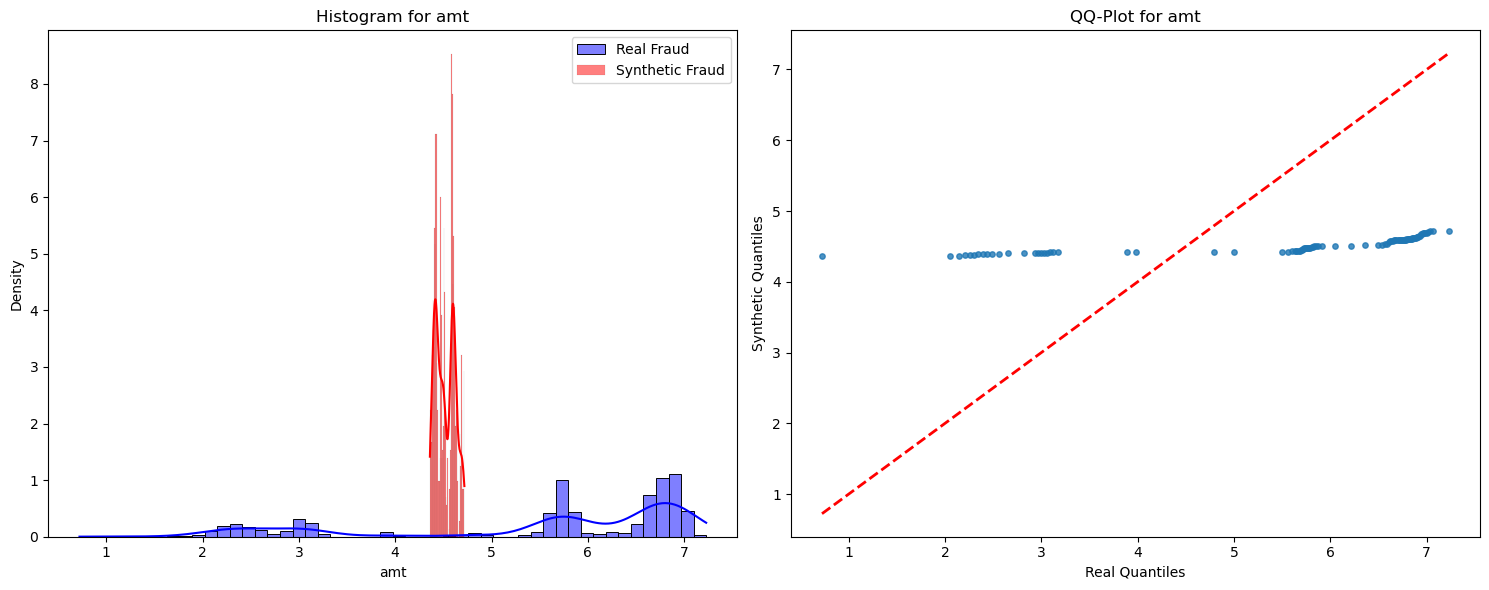

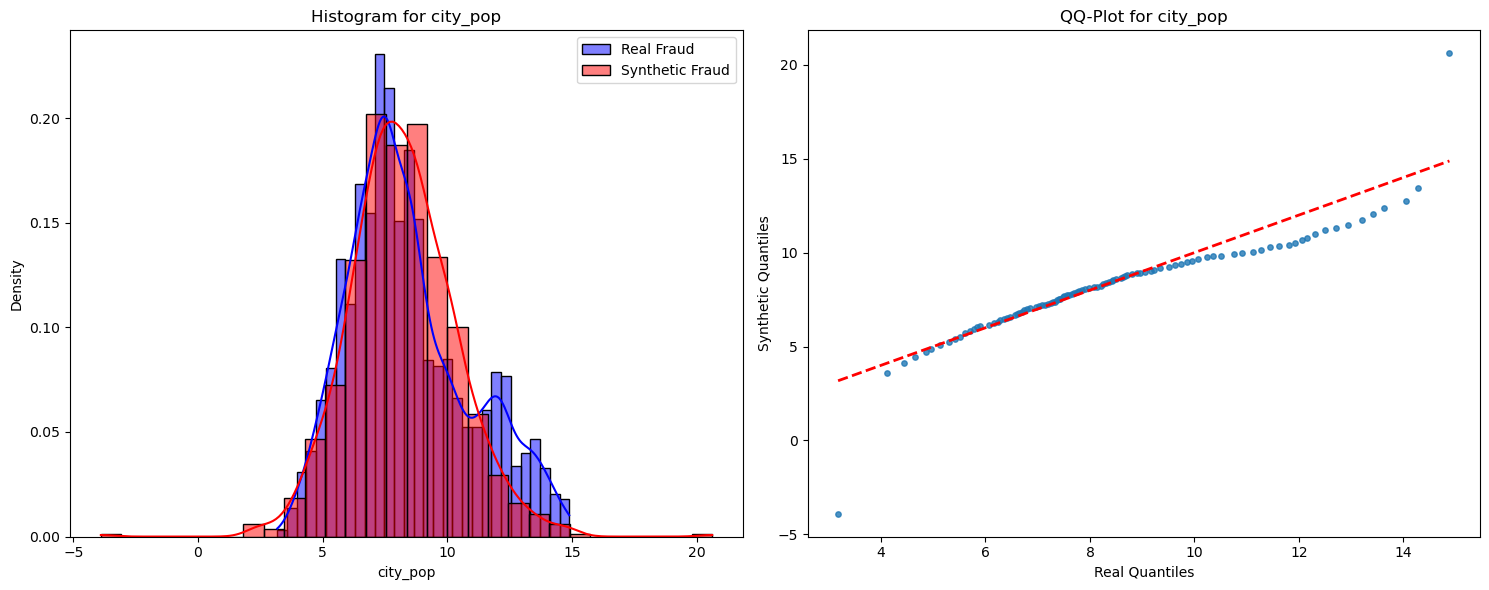

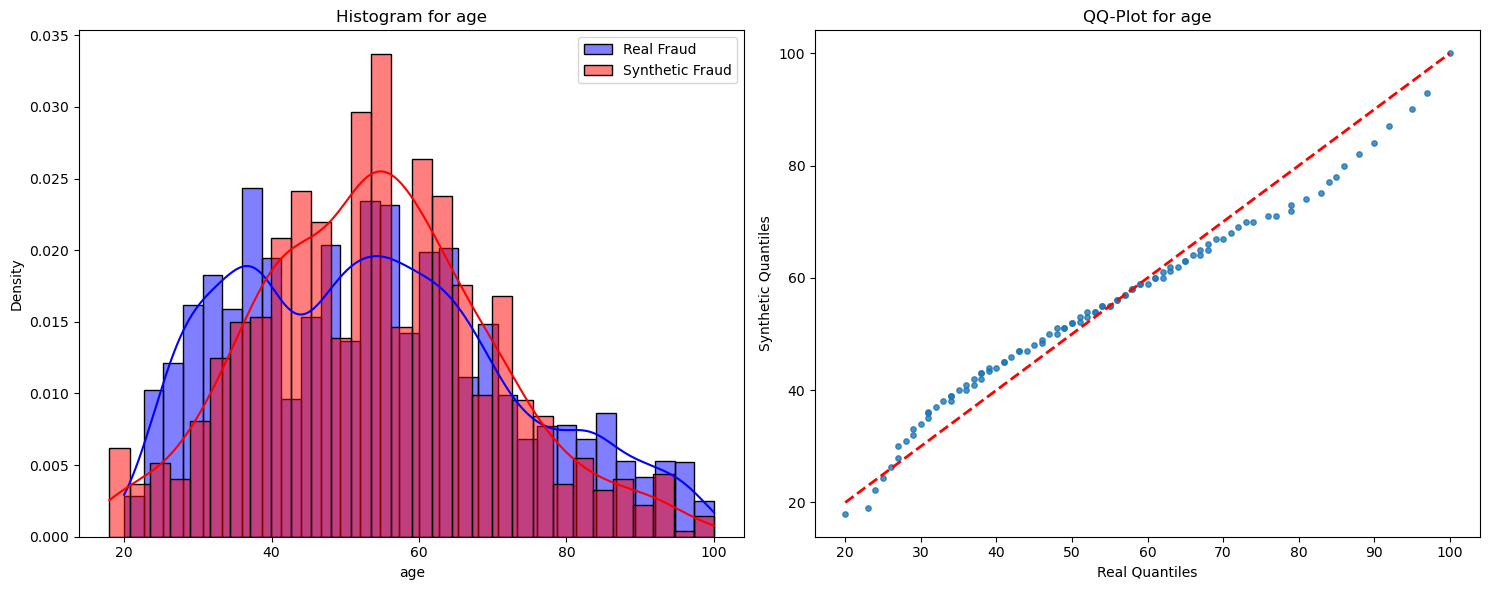

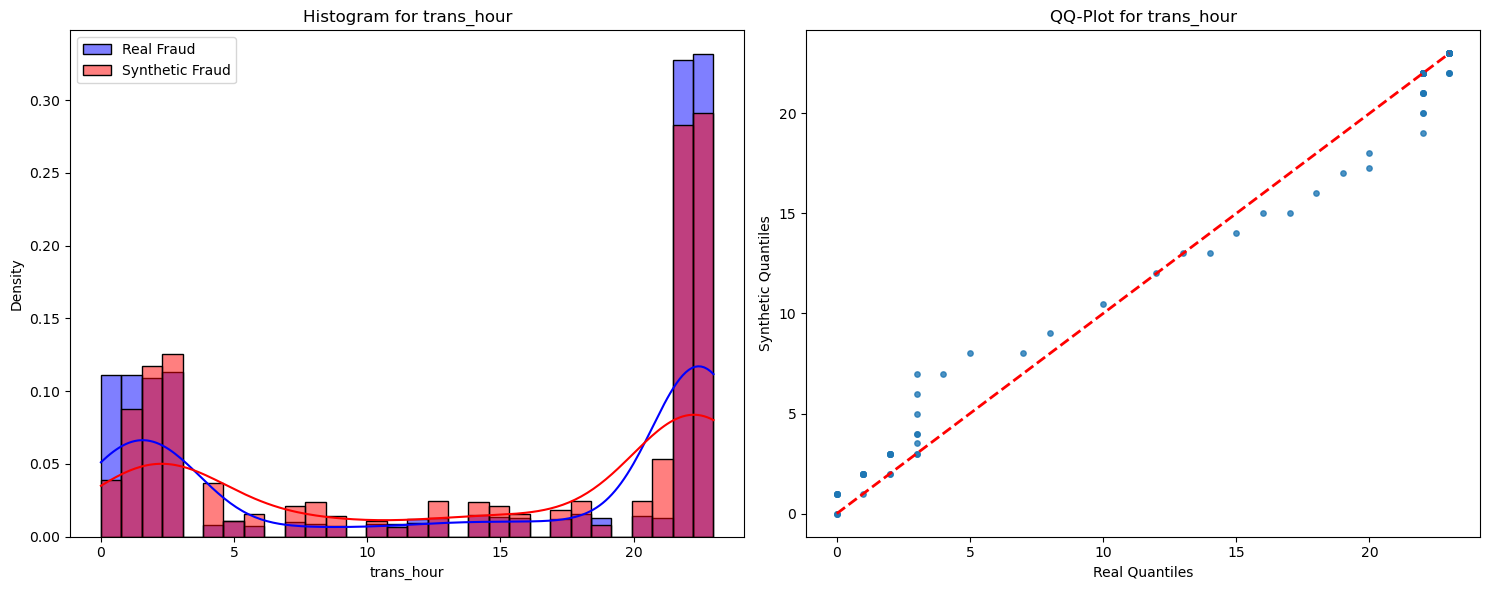

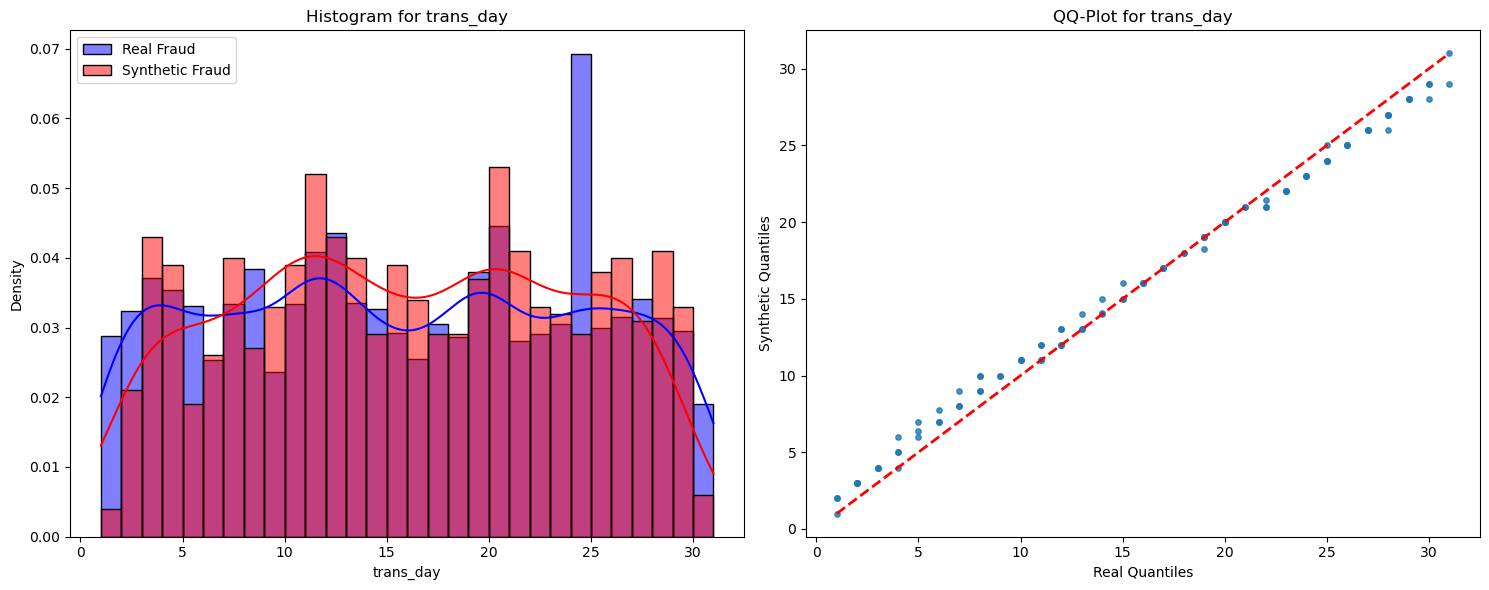

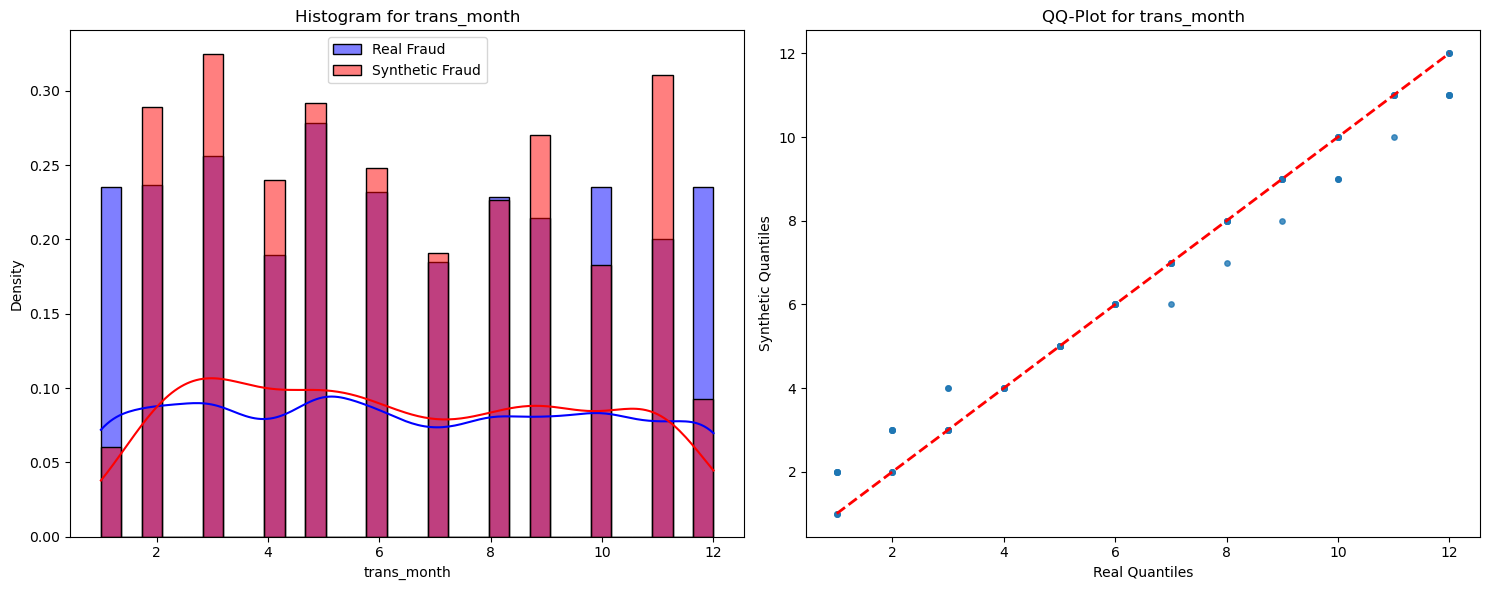

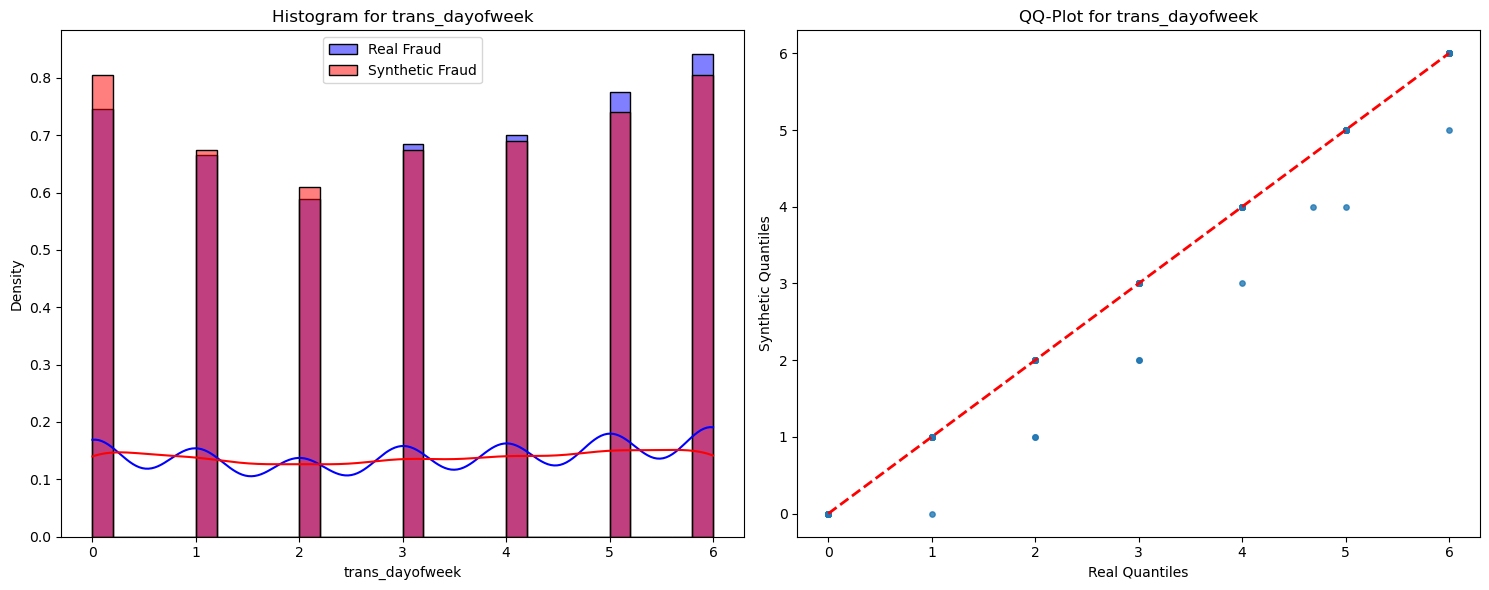

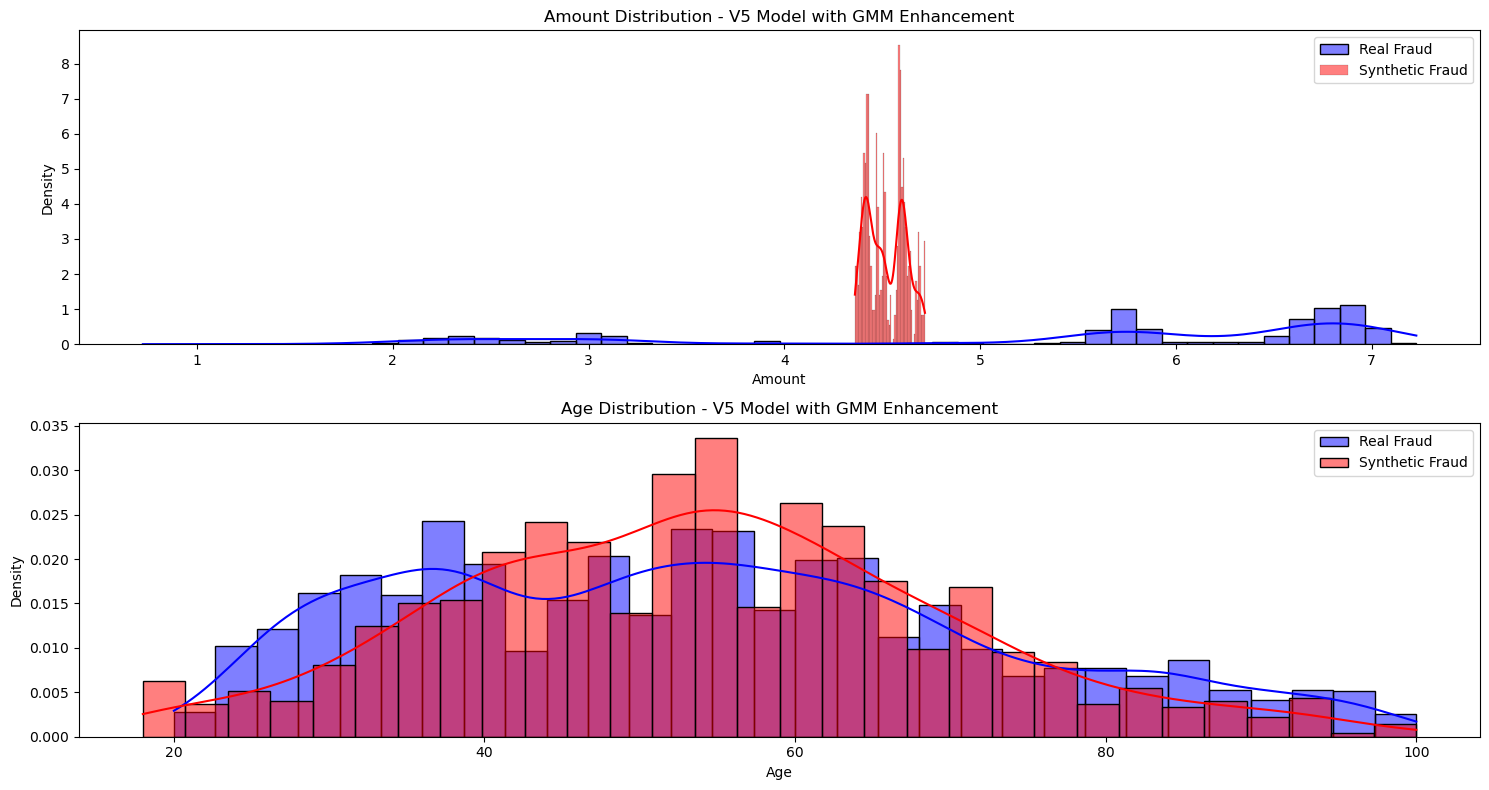

Evaluation complete.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import wasserstein_distance, energy_distance

#############################################
# Step 9: Evaluate Generated Synthetic Data (CORRECTED)
#############################################
# The synthetic_fraud_df is already generated and in original scale

# Get real fraud data and convert to original scale
X_fraud_scaled = X_train_df.loc[fraud_mask, numeric_features].values
# Inverse transform to get the original scale
X_fraud_original = scaler.inverse_transform(X_fraud_scaled)
X_fraud_original_df = pd.DataFrame(X_fraud_original, columns=numeric_features)

print("Real Fraud Numeric Statistics (Original Scale):")
print(X_fraud_original_df.describe())
print("\nSynthetic Fraud Numeric Statistics:")
print(synthetic_fraud_df[numeric_features].describe())

#############################################
# Step 10: Enhanced Distribution Evaluation
#############################################
def calculate_tail_statistics(real, synth):
    """Calculate comprehensive distribution comparison metrics"""
    return {
        'wasserstein': wasserstein_distance(real, synth),
        'energy': energy_distance(real, synth),
        'tail_ratio_95': np.quantile(synth, 0.95)/np.quantile(real, 0.95),
        'tail_ratio_99': np.quantile(synth, 0.99)/np.quantile(real, 0.99),
        'mean_ratio': np.mean(synth)/np.mean(real),
        'std_ratio': np.std(synth)/np.std(real),
        'skew_real': stats.skew(real),
        'skew_synth': stats.skew(synth)
    }

print("\nEnhanced Statistical Comparison")
print("============================================================")

for col in numeric_features:
    real_data = X_fraud_original_df[col].values  # Using original scale
    syn_data = synthetic_fraud_df[col].values
    
    # Statistical tests
    ks_result = stats.ks_2samp(real_data, syn_data)
    try:
        ad_result = stats.anderson_ksamp([real_data, syn_data])
        ad_stat = ad_result.statistic
        ad_signif = ad_result.significance_level
    except:
        ad_stat = float('nan')
        ad_signif = float('nan')
    
    # Calculate distribution statistics
    tail_stats = calculate_tail_statistics(real_data, syn_data)
    
    print(f"\nFeature: {col}")
    print("------------------------------------------------------------")
    print(f"KS Statistic: {ks_result.statistic:.4f}, p-value: {ks_result.pvalue:.4f}")
    print(f"Anderson–Darling Statistic: {ad_stat:.4f}, significance level: {ad_signif:.4f}")
    print(f"Real Skewness: {tail_stats['skew_real']:.4f}, Synthetic Skewness: {tail_stats['skew_synth']:.4f}")
    print(f"Real Kurtosis: {stats.kurtosis(real_data):.4f}, Synthetic Kurtosis: {stats.kurtosis(syn_data):.4f}")
    print(f"Wasserstein Distance: {tail_stats['wasserstein']:.4f}")
    print(f"Energy Distance: {tail_stats['energy']:.4f}")
    print(f"95th Percentile Ratio (Synth/Real): {tail_stats['tail_ratio_95']:.4f}")
    print(f"99th Percentile Ratio (Synth/Real): {tail_stats['tail_ratio_99']:.4f}")
    print("------------------------------------------------------------")

#############################################
# Step 11: Visualizations (No Saving)
#############################################
def plot_comparison(feature, bins=30):
    plt.figure(figsize=(15, 6))
    
    # Histogram comparison
    plt.subplot(1, 2, 1)
    sns.histplot(X_fraud_original_df[feature], color='blue', label='Real Fraud', kde=True, bins=bins, stat="density")
    sns.histplot(synthetic_fraud_df[feature], color='red', label='Synthetic Fraud', kde=True, bins=bins, stat="density")
    plt.legend()
    plt.title(f"Histogram for {feature}")
    plt.xlabel(feature)
    plt.ylabel("Density")
    
    # QQ plot
    plt.subplot(1, 2, 2)
    
    # Get real and synthetic data for this feature
    real_data = X_fraud_original_df[feature].values
    syn_data = synthetic_fraud_df[feature].values
    
    # Compute the quantiles
    quantiles_real = np.percentile(real_data, np.linspace(0, 100, 100))
    quantiles_syn = np.percentile(syn_data, np.linspace(0, 100, 100))
    
    # Plot the QQ plot
    plt.scatter(quantiles_real, quantiles_syn, alpha=0.8, s=15)
    plt.plot([min(quantiles_real), max(quantiles_real)], 
             [min(quantiles_real), max(quantiles_real)], 
             'r--', linewidth=2)
    
    plt.title(f"QQ-Plot for {feature}")
    plt.xlabel("Real Quantiles")
    plt.ylabel("Synthetic Quantiles")
    
    plt.tight_layout()
    plt.show()

# Visualize key features
for feature in ['amt', 'city_pop', 'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']:
    plot_comparison(feature, bins=30 if feature != 'amt' else 50)

#############################################
# Step 12: Special Focus on Amount and Age
#############################################
# Let's look closer at the bimodal patterns we targeted
plt.figure(figsize=(15, 8))

# Amount distribution with KDE for better visualization of modes
plt.subplot(2, 1, 1)
sns.histplot(X_fraud_original_df['amt'], color='blue', label='Real Fraud', kde=True, bins=50, stat="density")
sns.histplot(synthetic_fraud_df['amt'], color='red', label='Synthetic Fraud', kde=True, bins=50, stat="density")
plt.legend()
plt.title("Amount Distribution - V5 Model with GMM Enhancement")
plt.xlabel("Amount")
plt.ylabel("Density")

# Age distribution 
plt.subplot(2, 1, 2)
sns.histplot(X_fraud_original_df['age'], color='blue', label='Real Fraud', kde=True, bins=30, stat="density")
sns.histplot(synthetic_fraud_df['age'], color='red', label='Synthetic Fraud', kde=True, bins=30, stat="density")
plt.legend()
plt.title("Age Distribution - V5 Model with GMM Enhancement")
plt.xlabel("Age")
plt.ylabel("Density")

plt.tight_layout()
plt.show()

print("Evaluation complete.")

Real Fraud Numeric Statistics (Original Scale):
               amt          lat         long     city_pop    merch_lat  \
count  6273.000000  6273.000000  6273.000000  6273.000000  6273.000000   
mean    528.058148    38.720264   -90.184813     8.427249    38.711249   
std     390.115998     5.105659    14.214259     2.443052     5.140975   
min       1.060000    20.027100  -165.672300     3.178054    19.161782   
25%     238.780000    34.990600   -96.790900     6.679599    35.018202   
50%     386.040000    39.455800   -87.366700     7.940228    39.451233   
75%     899.490000    42.176700   -80.057300     9.893639    42.062039   
max    1376.040000    66.693300   -67.950300    14.882529    67.188111   

        merch_long          age   trans_hour    trans_day  trans_month  \
count  6273.000000  6273.000000  6273.000000  6273.000000  6273.000000   
mean    -90.185544    53.622669    13.961263    15.704448     6.399490   
std      14.234361    18.726013     9.707272     8.773384     3

C:\Users\raghu\AppData\Local\Temp\ipykernel_67792\3888603023.py:64: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_result = stats.anderson_ksamp([real_data, syn_data])
C:\Users\raghu\AppData\Local\Temp\ipykernel_67792\3888603023.py:64: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  ad_result = stats.anderson_ksamp([real_data, syn_data])



Feature: merch_long
------------------------------------------------------------
KS Statistic: 0.1108, p-value: 0.0000
Anderson–Darling Statistic: 15.1991, significance level: 0.0010
Real Skewness: -1.2078, Synthetic Skewness: -0.5577
Real Kurtosis: 1.9799, Synthetic Kurtosis: 0.2188
Wasserstein Distance: 2.3433
Energy Distance: 0.5413
95th Percentile Ratio (Synth/Real): 0.9919
99th Percentile Ratio (Synth/Real): 1.0109
------------------------------------------------------------

Feature: age
------------------------------------------------------------
KS Statistic: 0.0981, p-value: 0.0000
Anderson–Darling Statistic: 17.7405, significance level: 0.0010
Real Skewness: 0.3774, Synthetic Skewness: 0.2153
Real Kurtosis: -0.6331, Synthetic Kurtosis: -0.0953
Wasserstein Distance: 3.0551
Energy Distance: 0.5737
95th Percentile Ratio (Synth/Real): 0.9318
99th Percentile Ratio (Synth/Real): 0.9589
------------------------------------------------------------

Feature: trans_hour
--------------

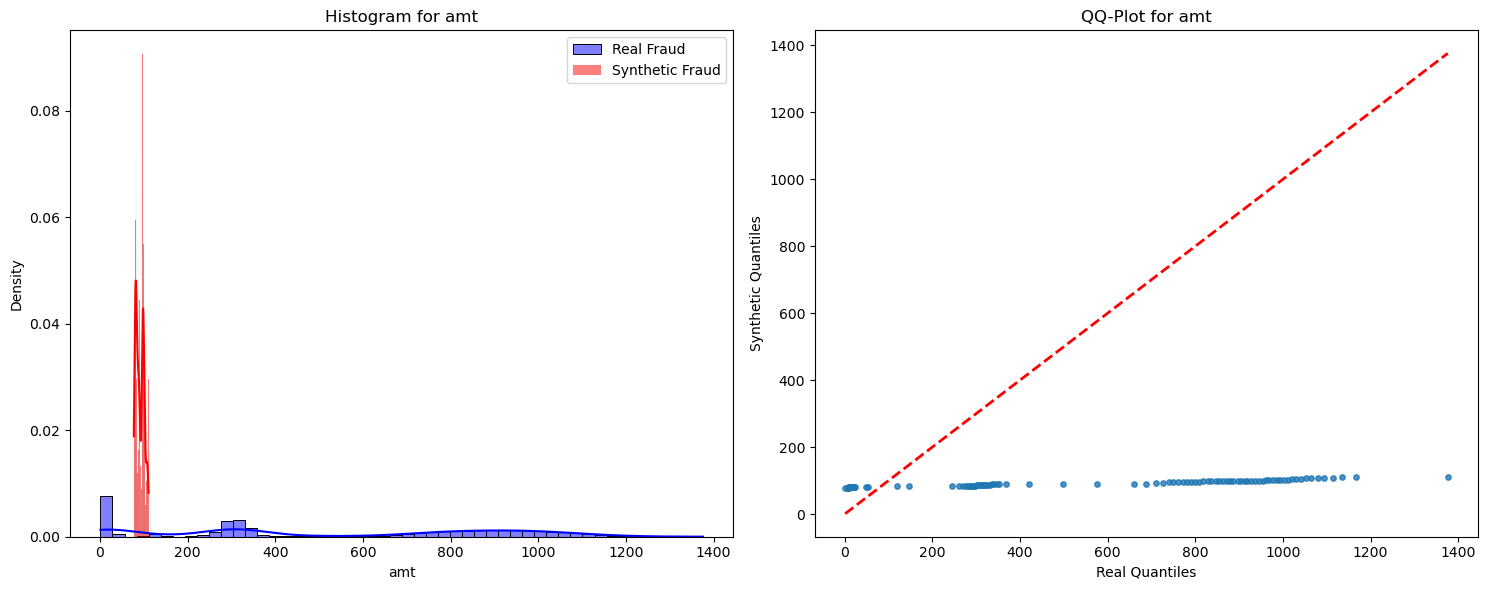

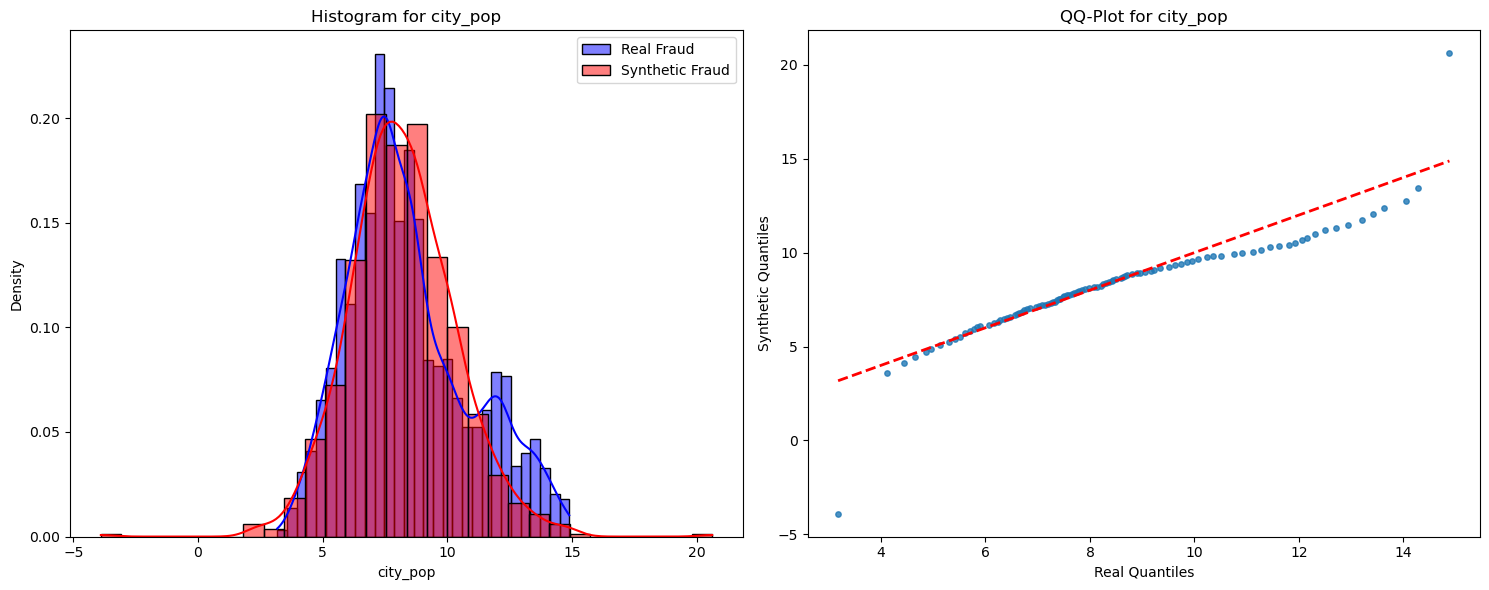

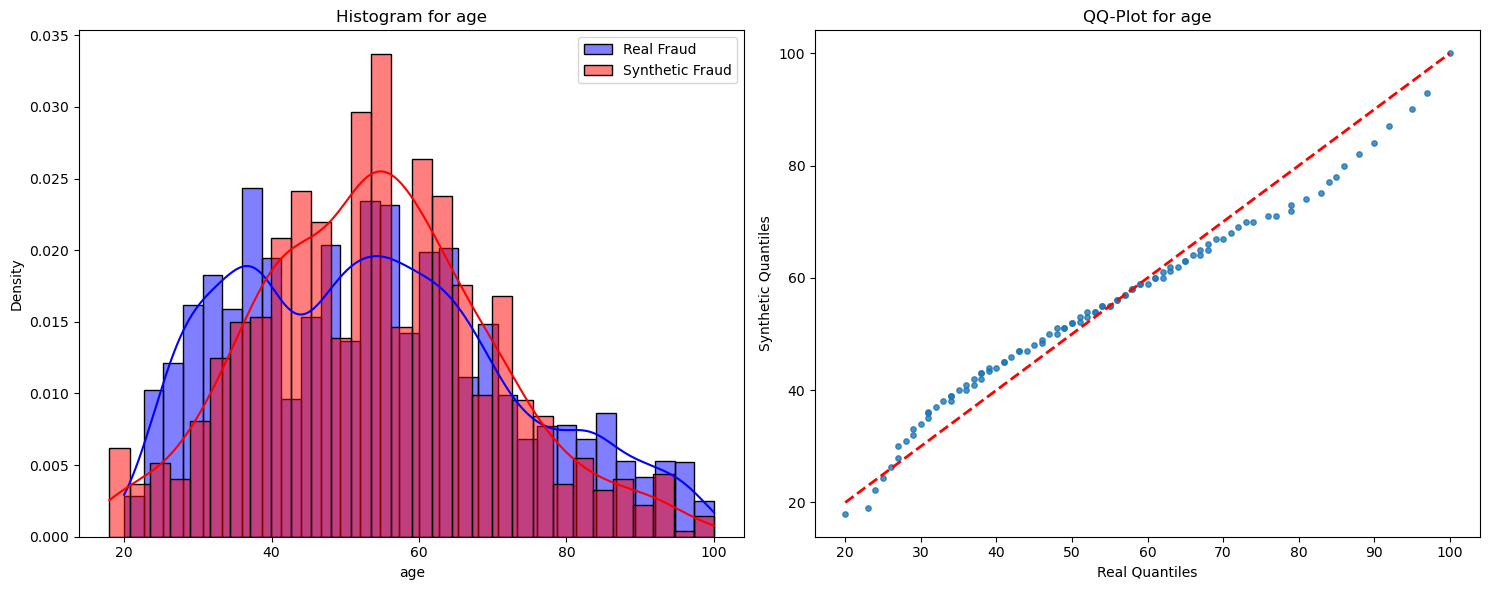

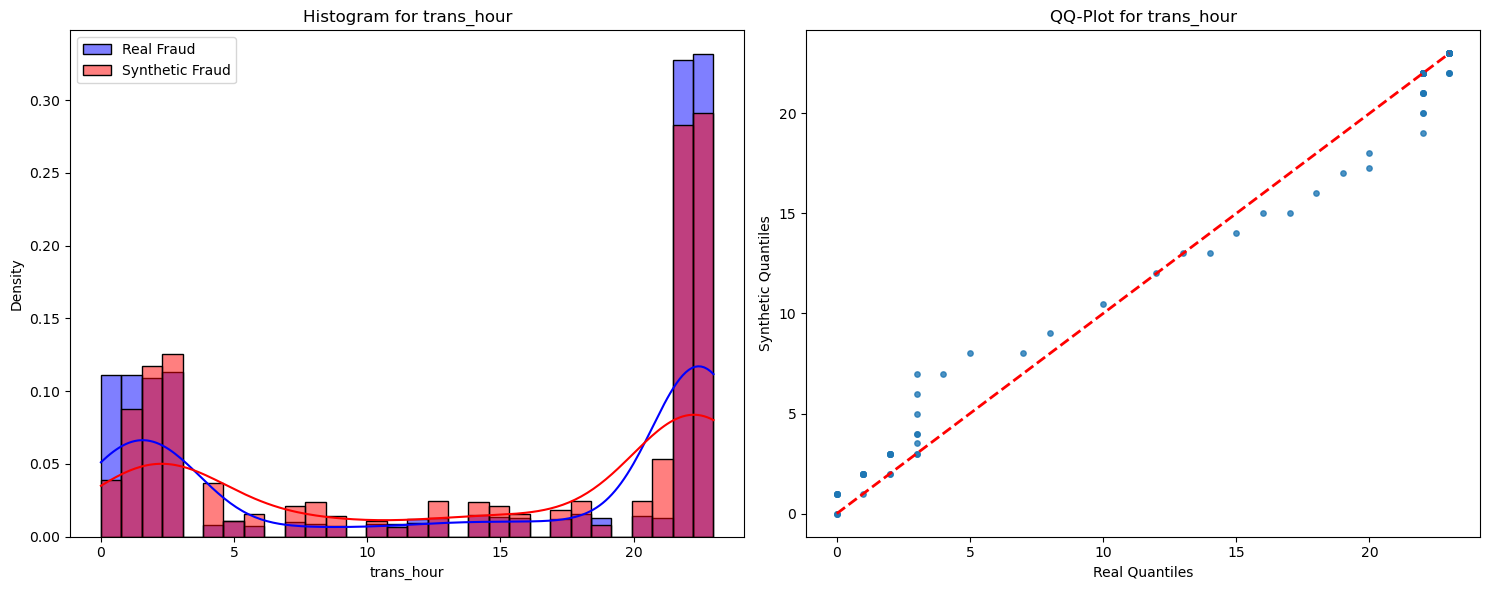

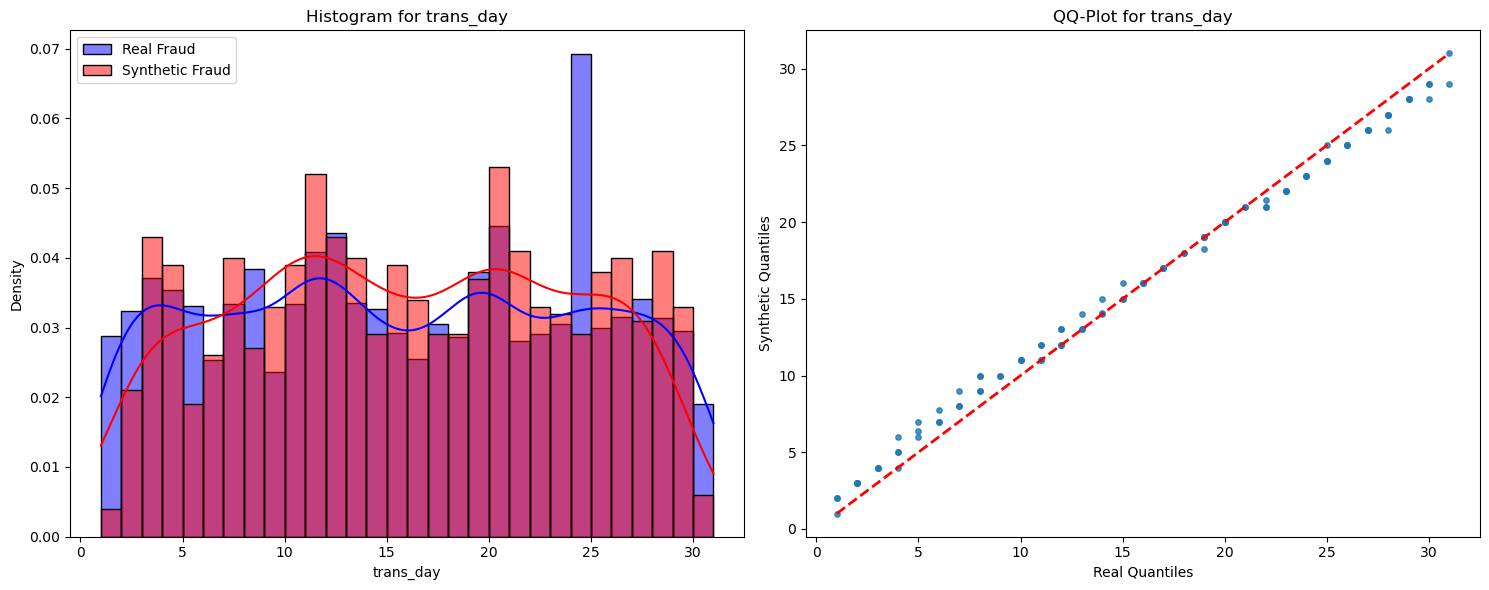

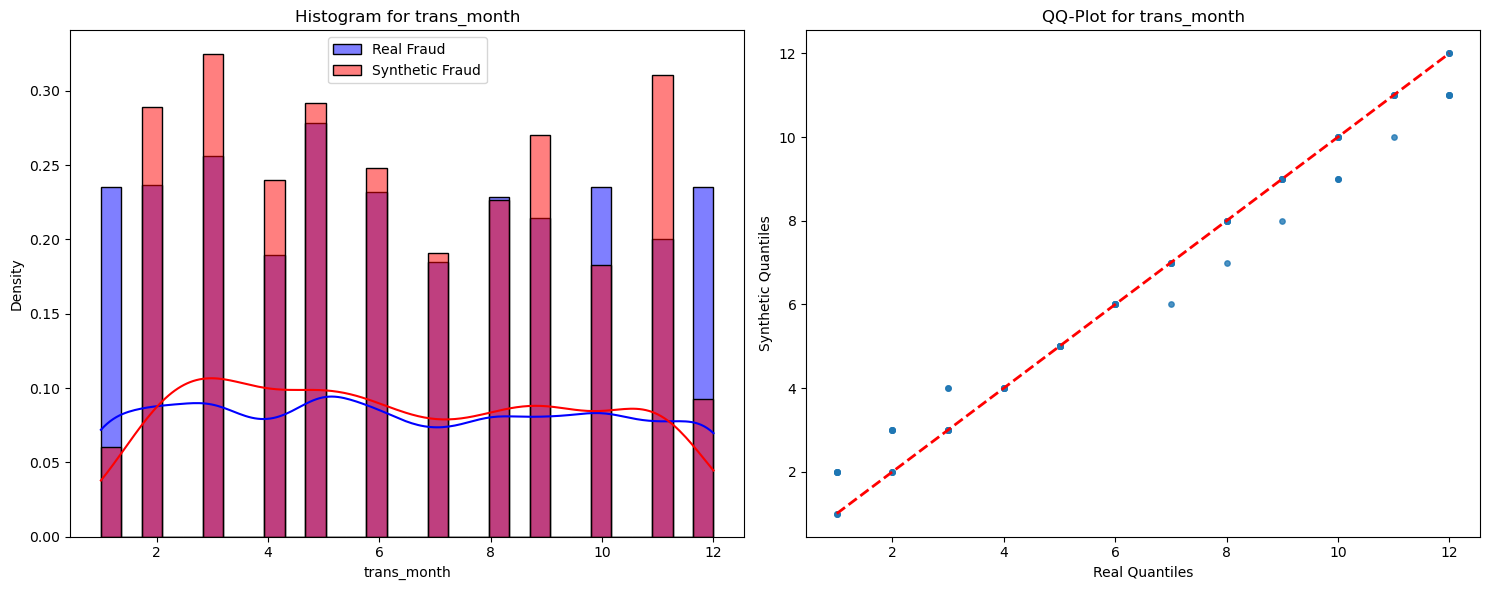

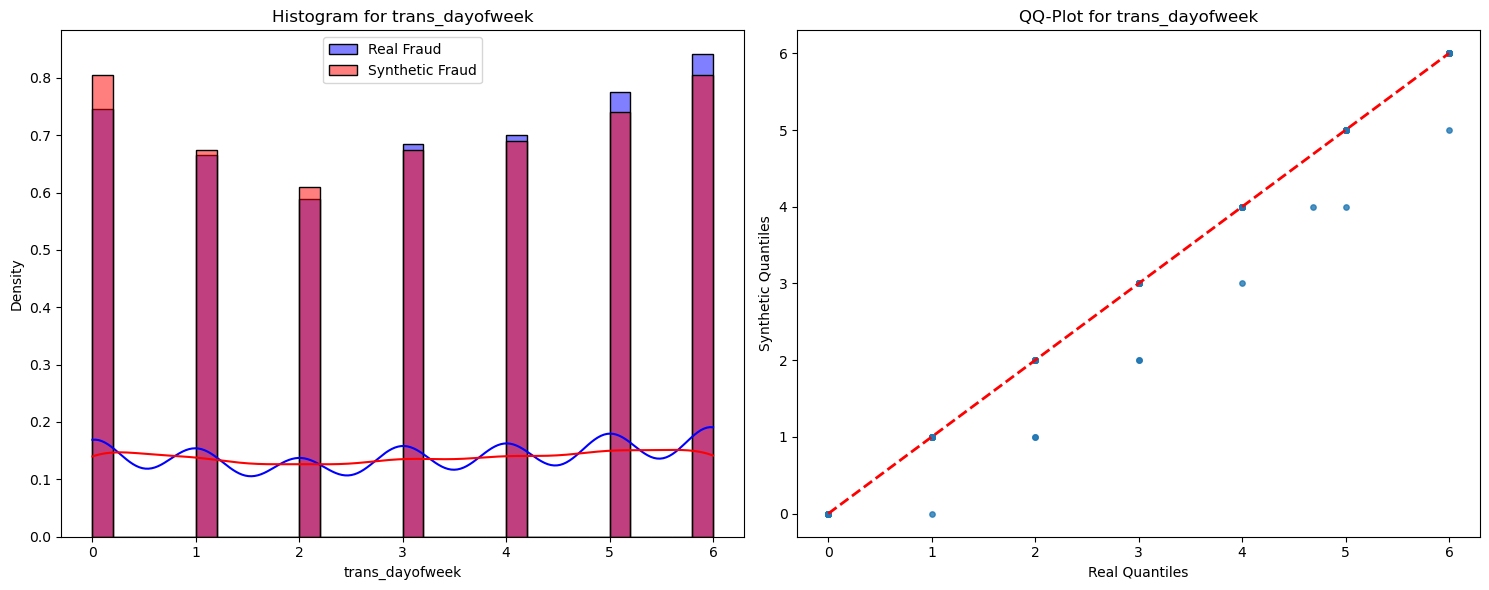

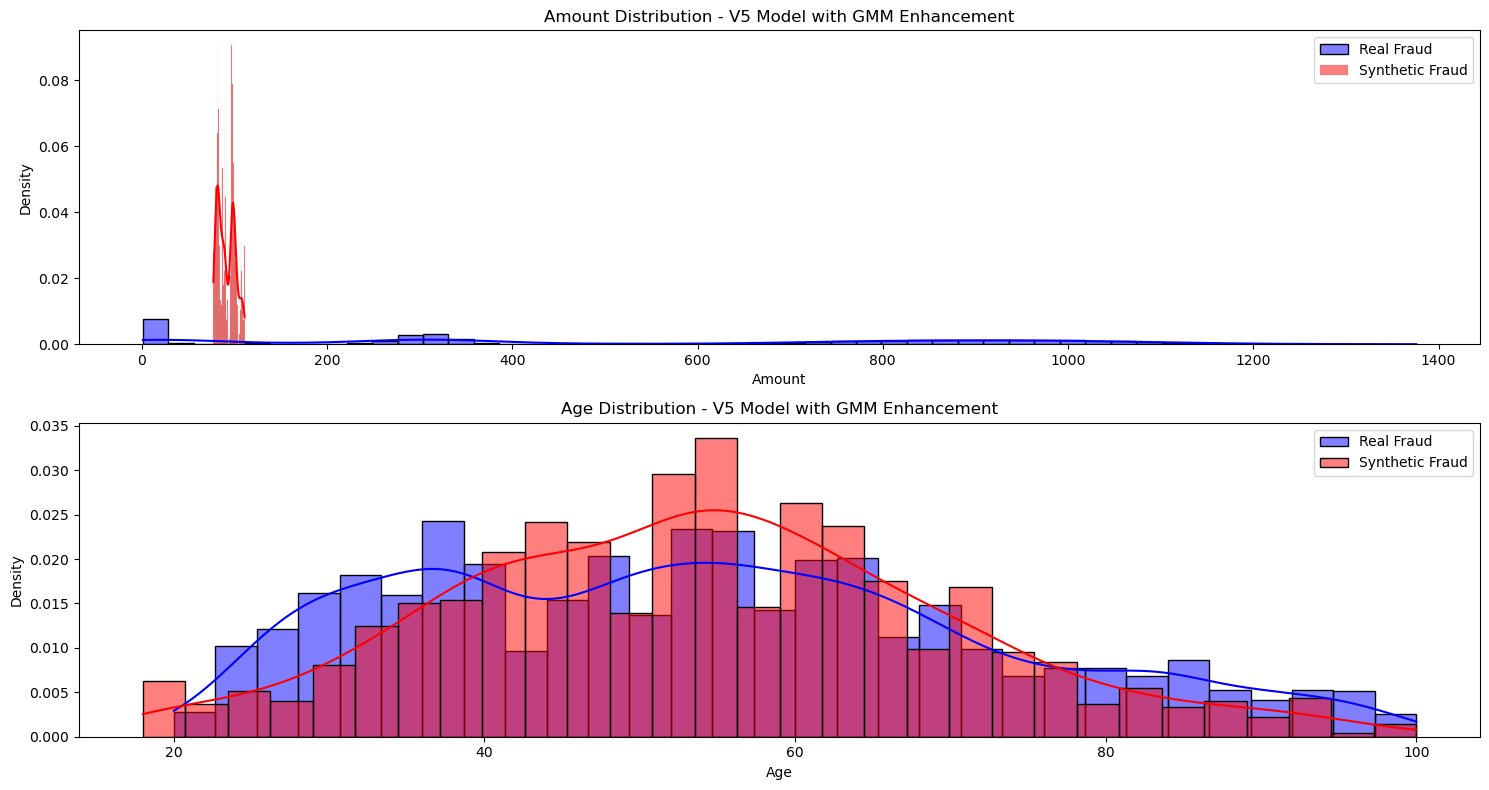

Evaluation complete.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import wasserstein_distance, energy_distance

#############################################
# Step 9: CORRECTED - Apply Missing Inverse Log Transforms
#############################################
# The synthetic_fraud_df is already generated but missing inverse log transforms

# Apply inverse log transform to features that were log-transformed during preprocessing
log_transformed_features = ['amt']

# Create corrected version of synthetic data with proper inverse transforms
synthetic_fraud_df_corrected = synthetic_fraud_df.copy()

# Apply expm1 to undo the log1p transformation
for feature in log_transformed_features:
    synthetic_fraud_df_corrected[feature] = np.expm1(synthetic_fraud_df_corrected[feature])

# Get real fraud data and convert to original scale
X_fraud_scaled = X_train_df.loc[fraud_mask, numeric_features].values
# Inverse transform to get the original scale
X_fraud_original = scaler.inverse_transform(X_fraud_scaled)
X_fraud_original_df = pd.DataFrame(X_fraud_original, columns=numeric_features)

# Also apply expm1 to the same features in the real data
for feature in log_transformed_features:
    X_fraud_original_df[feature] = np.expm1(X_fraud_original_df[feature])

print("Real Fraud Numeric Statistics (Original Scale):")
print(X_fraud_original_df.describe())
print("\nSynthetic Fraud Numeric Statistics (Corrected):")
print(synthetic_fraud_df_corrected[numeric_features].describe())

#############################################
# Step 10: Enhanced Distribution Evaluation
#############################################
def calculate_tail_statistics(real, synth):
    """Calculate comprehensive distribution comparison metrics"""
    return {
        'wasserstein': wasserstein_distance(real, synth),
        'energy': energy_distance(real, synth),
        'tail_ratio_95': np.quantile(synth, 0.95)/np.quantile(real, 0.95),
        'tail_ratio_99': np.quantile(synth, 0.99)/np.quantile(real, 0.99),
        'mean_ratio': np.mean(synth)/np.mean(real),
        'std_ratio': np.std(synth)/np.std(real),
        'skew_real': stats.skew(real),
        'skew_synth': stats.skew(synth)
    }

print("\nEnhanced Statistical Comparison")
print("============================================================")

for col in numeric_features:
    real_data = X_fraud_original_df[col].values
    syn_data = synthetic_fraud_df_corrected[col].values
    
    # Statistical tests
    ks_result = stats.ks_2samp(real_data, syn_data)
    try:
        ad_result = stats.anderson_ksamp([real_data, syn_data])
        ad_stat = ad_result.statistic
        ad_signif = ad_result.significance_level
    except:
        ad_stat = float('nan')
        ad_signif = float('nan')
    
    # Calculate distribution statistics
    tail_stats = calculate_tail_statistics(real_data, syn_data)
    
    print(f"\nFeature: {col}")
    print("------------------------------------------------------------")
    print(f"KS Statistic: {ks_result.statistic:.4f}, p-value: {ks_result.pvalue:.4f}")
    print(f"Anderson–Darling Statistic: {ad_stat:.4f}, significance level: {ad_signif:.4f}")
    print(f"Real Skewness: {tail_stats['skew_real']:.4f}, Synthetic Skewness: {tail_stats['skew_synth']:.4f}")
    print(f"Real Kurtosis: {stats.kurtosis(real_data):.4f}, Synthetic Kurtosis: {stats.kurtosis(syn_data):.4f}")
    print(f"Wasserstein Distance: {tail_stats['wasserstein']:.4f}")
    print(f"Energy Distance: {tail_stats['energy']:.4f}")
    print(f"95th Percentile Ratio (Synth/Real): {tail_stats['tail_ratio_95']:.4f}")
    print(f"99th Percentile Ratio (Synth/Real): {tail_stats['tail_ratio_99']:.4f}")
    print("------------------------------------------------------------")

#############################################
# Step 11: Visualizations (No Saving)
#############################################
def plot_comparison(feature, bins=30):
    plt.figure(figsize=(15, 6))
    
    # Histogram comparison
    plt.subplot(1, 2, 1)
    sns.histplot(X_fraud_original_df[feature], color='blue', label='Real Fraud', kde=True, bins=bins, stat="density")
    sns.histplot(synthetic_fraud_df_corrected[feature], color='red', label='Synthetic Fraud', kde=True, bins=bins, stat="density")
    plt.legend()
    plt.title(f"Histogram for {feature}")
    plt.xlabel(feature)
    plt.ylabel("Density")
    
    # QQ plot
    plt.subplot(1, 2, 2)
    
    # Get real and synthetic data for this feature
    real_data = X_fraud_original_df[feature].values
    syn_data = synthetic_fraud_df_corrected[feature].values
    
    # Compute the quantiles
    quantiles_real = np.percentile(real_data, np.linspace(0, 100, 100))
    quantiles_syn = np.percentile(syn_data, np.linspace(0, 100, 100))
    
    # Plot the QQ plot
    plt.scatter(quantiles_real, quantiles_syn, alpha=0.8, s=15)
    plt.plot([min(quantiles_real), max(quantiles_real)], 
             [min(quantiles_real), max(quantiles_real)], 
             'r--', linewidth=2)
    
    plt.title(f"QQ-Plot for {feature}")
    plt.xlabel("Real Quantiles")
    plt.ylabel("Synthetic Quantiles")
    
    plt.tight_layout()
    plt.show()

# Visualize key features
for feature in ['amt', 'city_pop', 'age', 'trans_hour', 'trans_day', 'trans_month', 'trans_dayofweek']:
    plot_comparison(feature, bins=30 if feature != 'amt' else 50)

#############################################
# Step 12: Special Focus on Amount and Age
#############################################
# Let's look closer at the bimodal patterns we targeted
plt.figure(figsize=(15, 8))

# Amount distribution with KDE for better visualization of modes
plt.subplot(2, 1, 1)
sns.histplot(X_fraud_original_df['amt'], color='blue', label='Real Fraud', kde=True, bins=50, stat="density")
sns.histplot(synthetic_fraud_df_corrected['amt'], color='red', label='Synthetic Fraud', kde=True, bins=50, stat="density")
plt.legend()
plt.title("Amount Distribution - V5 Model with GMM Enhancement")
plt.xlabel("Amount")
plt.ylabel("Density")

# Age distribution 
plt.subplot(2, 1, 2)
sns.histplot(X_fraud_original_df['age'], color='blue', label='Real Fraud', kde=True, bins=30, stat="density")
sns.histplot(synthetic_fraud_df_corrected['age'], color='red', label='Synthetic Fraud', kde=True, bins=30, stat="density")
plt.legend()
plt.title("Age Distribution - V5 Model with GMM Enhancement")
plt.xlabel("Age")
plt.ylabel("Density")

plt.tight_layout()
plt.show()

print("Evaluation complete.")